# Data preparation and exploration for the machine learning problem ' Identify key aspects of a Review ' 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re


matplotlib.style.use('fivethirtyeight') 

## Importing tha data

In [2]:
df = pd.read_csv('Dataset/train.csv')

print("number of examples in dataset = ",df.shape[0])
print("number of columns in dataset = ",df.shape[1])
print("number of labels in dataset = ",df['topic'].nunique())

df.head()

number of examples in dataset =  5959
number of columns in dataset =  3
number of labels in dataset =  21


Review Text  \
0  Did nothing for me, didn't help lost even with...   
1  Did nothing for me, didn't help lost even with...   
2  I have bought these bags and  immediately open...   
3         Gave me an allergic reaction on my face :(   
4  These don't compare to the name brand wipes. F...   

                                        Review Title                  topic  
0                                            Useless  Shipment and delivery  
1                                            Useless          Not Effective  
2  TRASH!!! Do not buy these bags it’s a waist of...       Customer Service  
3                                   Do not recommend               Allergic  
4                            Can't tackle big messes                Texture

# Data Processing

## 1. Data Cleaning

### *Messing values*

In [3]:
print(df.isna().sum())

Review Text     0
Review Title    0
topic           0
dtype: int64


*==> There is no messing data in our dataset*

### *Null values*

In [4]:
print(df.isnull().sum())

Review Text     0
Review Title    0
topic           0
dtype: int64


*==> There is no null values in our dataset*

### *Duplicate values*

In [5]:
print(df.duplicated().sum())

11


In [6]:
#droping dublicate values

df = df.drop_duplicates().reset_index(drop=True)

## 2. Data Transformation

### *Encoding*

In [7]:
####Encoding the labels####

from sklearn.preprocessing import OneHotEncoder

target = np.array(df['topic']).reshape(-1, 1)
encoder = OneHotEncoder(dtype = int).fit(target)
topics = encoder.categories_[0]
values = encoder.transform(target)

topic_encoded = pd.DataFrame(values.toarray(), columns=topics)

df.drop('topic',axis = 1,inplace=True)
df = pd.concat([df, topic_encoded],axis = 1)


In [8]:
####Combining the examples with multiple labels#####

#Creat a dataFrame to stock the new structured data
data = pd.DataFrame(columns = df.columns)

#Looping over the unique review texts
for review in df['Review Text'].unique(): 
    
    #selecting the subData having the same review text
    review_raws = df[df['Review Text'] == review]
    
    #selecting the title of our review text and wraping the results in a Pandas Serie
    TextAndTitle = pd.Series(data = [review,review_raws['Review Title'].unique()[0]], index = ['Review Text','Review Title'])
     
    #combining the labels raws in one raw
    labels = review_raws[topics].sum()
    
    #Merging all results to our data new dataframe
    data = data.append(pd.concat([TextAndTitle,labels]),ignore_index=True)
    
data.head(3)

Review Text  \
0  Did nothing for me, didn't help lost even with...   
1  I have bought these bags and  immediately open...   
2         Gave me an allergic reaction on my face :(   

                                        Review Title Allergic  \
0                                            Useless        0   
1  TRASH!!! Do not buy these bags it’s a waist of...        0   
2                                   Do not recommend        1   

  Bad Taste/Flavor Color and texture Customer Issues Customer Service  \
0                0                 0               0                0   
1                0                 0               0                1   
2                0                 0               0                0   

  Didn't Like Expiry False Advertisement  ... Not Effective Packaging Pricing  \
0           0      0                   0  ...             1         0       0   
1           0      0                   0  ...             0         0       0   
2           0      0                   0  ...             0         0       0   

  Quality/Contaminated Shipment and delivery Smells Bad Texture Too Sweet  \
0                    0                     1          0       0         0   
1                    0                     0          0       0         0   
2                    0                     0          0       0         0   

  Too big to swallow Wrong Product received  
0                  0                      0  
1                  0                      0  
2                  0                      0  

[3 rows x 23 columns]

### *Removing punctuation*

In [9]:
import string

#defining a fucntion so we can apply it to each example
def removePunctuation(text):
    #selecting only non punctuation words
    temp = [ words for words in text if words not in string.punctuation]
    #returning results in one text
    return ''.join(temp)

#applying the function using the lambda expression
data['Review Text'] = data['Review Text'].apply(lambda review : removePunctuation(review))
data['Review Title'] = data['Review Title'].apply(lambda review : removePunctuation(review))

data.iloc[:,:2].head()

Review Text  \
0  Did nothing for me didnt help lost even with w...   
1  I have bought these bags and  immediately open...   
2           Gave me an allergic reaction on my face    
3  These dont compare to the name brand wipes Fam...   
4                                            No good   

                                       Review Title  
0                                           Useless  
1  TRASH Do not buy these bags it’s a waist of time  
2                                  Do not recommend  
3                            Cant tackle big messes  
4                                   Tastes horrible

### *Expanding Contractions*

In [10]:
import contractions

#defining a fucntion so we can apply it to each example
def expandContractions(text):
    #creating an empty list
    expanded_words = []  
    for word in text.split():
        #using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))  
    #returning results as one text    
    return ' '.join(expanded_words)

#applying our function using the lambda expression
data['Review Text'] = data['Review Text'].apply(lambda review: expandContractions(review))
data['Review Title'] = data['Review Title'].apply(lambda review : expandContractions(review))

data.iloc[:,:2].head()

Review Text  \
0  Did nothing for me did not help lost even with...   
1  I have bought these bags and immediately open ...   
2            Gave me an allergic reaction on my face   
3  These do not compare to the name brand wipes F...   
4                                            No good   

                                        Review Title  
0                                            Useless  
1  TRASH Do not buy these bags it is a waist of time  
2                                   Do not recommend  
3                           Cannot tackle big messes  
4                                    Tastes horrible

In [11]:
from nltk.tokenize import word_tokenize

#Tokenize Review text and title columns
data['Review Text'] = data['Review Text'].apply(word_tokenize)
data['Review Title'] = data['Review Title'].apply(word_tokenize)

data.iloc[:,:2].head()

Review Text  \
0  [Did, nothing, for, me, did, not, help, lost, ...   
1  [I, have, bought, these, bags, and, immediatel...   
2   [Gave, me, an, allergic, reaction, on, my, face]   
3  [These, do, not, compare, to, the, name, brand...   
4                                         [No, good]   

                                        Review Title  
0                                          [Useless]  
1  [TRASH, Do, not, buy, these, bags, it, is, a, ...  
2                               [Do, not, recommend]  
3                    [Can, not, tackle, big, messes]  
4                                 [Tastes, horrible]

### *Converting all Characters to Lowercase*

In [12]:
#convert all words to lower case

data['Review Text'] = data['Review Text'].apply(lambda review: [word.lower() for word in review])
data['Review Title'] = data['Review Title'].apply(lambda review: [word.lower() for word in review])

data.iloc[:,:2].head()

Review Text  \
0  [did, nothing, for, me, did, not, help, lost, ...   
1  [i, have, bought, these, bags, and, immediatel...   
2   [gave, me, an, allergic, reaction, on, my, face]   
3  [these, do, not, compare, to, the, name, brand...   
4                                         [no, good]   

                                        Review Title  
0                                          [useless]  
1  [trash, do, not, buy, these, bags, it, is, a, ...  
2                               [do, not, recommend]  
3                    [can, not, tackle, big, messes]  
4                                 [tastes, horrible]

### *Removing Stopwords*

In [13]:
from nltk.corpus import stopwords, wordnet

#selecting the english stopWords since our reviews are English
stop_words = set(stopwords.words('english'))

data['Review Text'] = data['Review Text'].apply(lambda review: [word for word in review if word not in stop_words])
data['Review Title'] = data['Review Title'].apply(lambda review: [word for word in review if word not in stop_words])


data.iloc[:,:2].head()

Review Text  \
0  [nothing, help, lost, even, working, eating, h...   
1  [bought, bags, immediately, open, one, put, tr...   
2                   [gave, allergic, reaction, face]   
3  [compare, name, brand, wipes, family, 5, littl...   
4                                             [good]   

                      Review Title  
0                        [useless]  
1  [trash, buy, bags, waist, time]  
2                      [recommend]  
3            [tackle, big, messes]  
4               [tastes, horrible]

### *Removing numbers and emojis*

In [14]:
####Defining a function to remove all type of emojis####

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [15]:
####Removing numbers####
data['Review Text'] = data['Review Text'].apply(lambda review: [word for word in review if not word.isdigit()])
data['Review Title'] = data['Review Title'].apply(lambda review: [word for word in review if not word.isdigit()])

####removing emojis####
data['Review Text'] = data['Review Text'].apply(lambda review: [remove_emoji(word) for word in review])
data['Review Title'] = data['Review Title'].apply(lambda review: [remove_emoji(word) for word in review])

data.iloc[:,:2].head()

Review Text  \
0  [nothing, help, lost, even, working, eating, h...   
1  [bought, bags, immediately, open, one, put, tr...   
2                   [gave, allergic, reaction, face]   
3  [compare, name, brand, wipes, family, little, ...   
4                                             [good]   

                      Review Title  
0                        [useless]  
1  [trash, buy, bags, waist, time]  
2                      [recommend]  
3            [tackle, big, messes]  
4               [tastes, horrible]

### *Lemmatization*

#### (POS) tagging

We will need the POS in wordnet’s format tags for the Lemmatization process

In [16]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fatim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
from nltk.tag import pos_tag

#getting parts of speech tags for each example
data['pos_tags'] = data['Review Text'].apply(pos_tag)

#function to convert the tags to wordnet's format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#convertting tags to their wordnet's format
data['pos_tags'] = data['pos_tags'].apply(lambda x : [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

#### Lemmatization

In [18]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
data['Review Text'] = data['pos_tags'].apply(lambda x : [lemmatizer.lemmatize(word, tag) for word, tag in x])

data.drop('pos_tags',axis = 1,inplace=True)

data.iloc[:,:2].head()

Review Text  \
0  [nothing, help, lose, even, work, eat, healthy...   
1  [bought, bag, immediately, open, one, put, tra...   
2                   [give, allergic, reaction, face]   
3  [compare, name, brand, wipe, family, little, k...   
4                                             [good]   

                      Review Title  
0                        [useless]  
1  [trash, buy, bags, waist, time]  
2                      [recommend]  
3            [tackle, big, messes]  
4               [tastes, horrible]

# Data Exploration

### *Text statistics*

#### Text and topic

In [19]:
####Counting the number of reviews in each topic####

counts = []

#Sum over each topic column to get the number of reviews with that topic
for topic in topics :
    counts.append((topic,data[topic].sum()))

#Wrap the results in a dataframe ( for good structure and easy plot )
counts = pd.DataFrame(counts, columns=['topic', 'number of reviews'])

counts.head()

topic  number of reviews
0           Allergic                567
1   Bad Taste/Flavor               1193
2  Color and texture                233
3    Customer Issues                  8
4   Customer Service                239

Text(0, 0.5, 'Number of reviews')

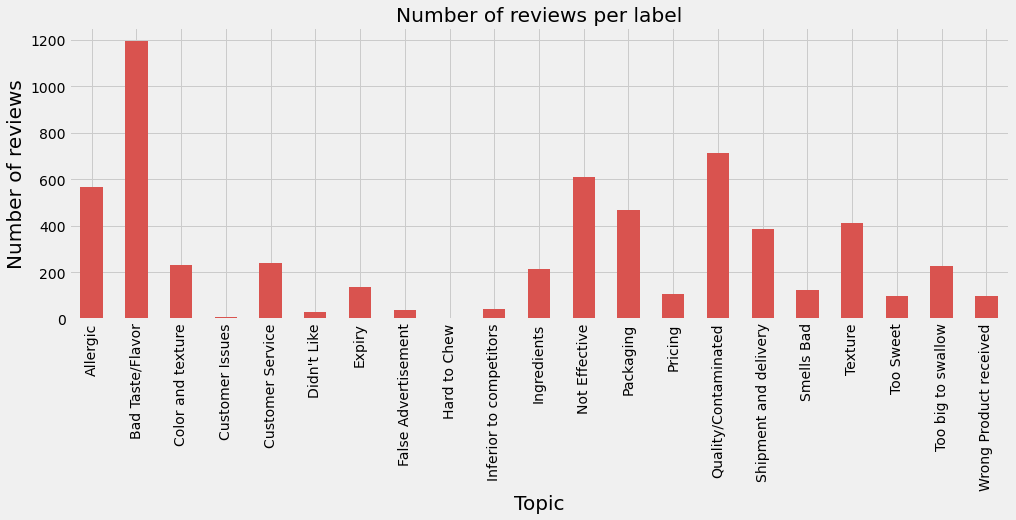

In [20]:
####Ploting results####

counts.plot(x='topic', y='number of reviews', kind='bar', legend=False, grid=True, figsize=(15,5), color='#d9534f')

plt.title("Number of reviews per label")
plt.xlabel('Topic', fontsize=20)
plt.ylabel('Number of reviews', fontsize=20)

<font size = "4">Classes seem very imbalanced <font><br><br>
<font size = "3">*Most reviews were about bad taste, quality, allergie and not effectivety, however reviews about topics "hard to cheh" and "customer issues" are almost null and this will cause a probelm at the training phase*<font>

In [21]:
####Counting the number of reviews with multiple topics####

#Sum the topics coulumns values over each example and wrap the results in a dataframe
multiCounts = data.iloc[:,2:].sum(axis= 1).value_counts().to_frame().reset_index().rename(columns = {'index' : 'number of topics',0:'number of reviews'})

multiCounts

number of topics  number of reviews
0               1.0               2882
1               2.0                966
2               3.0                277
3               4.0                 56
4               5.0                 11
5               6.0                  4

Text(0.5, 0, 'Reviews')

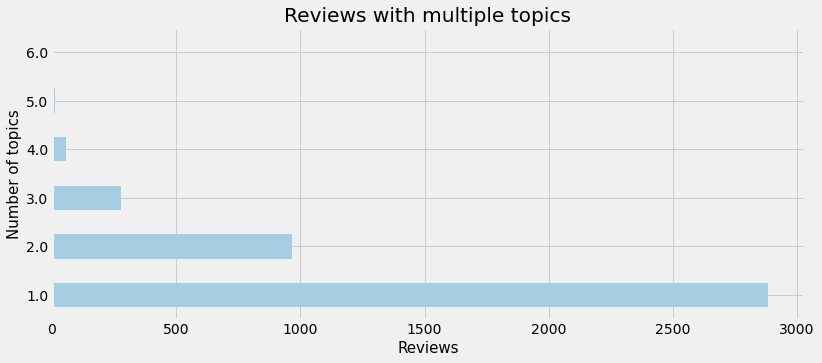

In [22]:
####Ploting results####

multiCounts.plot(x='number of topics', y='number of reviews', kind='barh', legend=False, grid=True, figsize=(12,5), colormap='Paired')

plt.title("Reviews with multiple topics")
plt.ylabel('Number of topics', fontsize=15)
plt.xlabel('Reviews', fontsize=15)

<font size = "3">*Most reviews are about 1 topic or 2* </font>

#### distribution of the number of words

<AxesSubplot:>

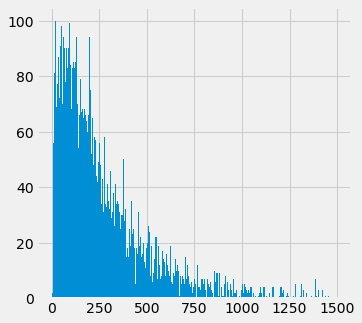

In [23]:
####The distribution of the number of words within each review####

dist = df['Review Text'].str.len()
dist.hist(bins = np.arange(0,1500,5),figsize = (5,5))

<font size = "3">*Most of the review text length are within 500 characters, with some outliers up to 1500 characters long.*<font>

### *WordCloud*

<font size = "3">*WordClouds are good maner of analyzing feedbacks and customer's reviews in ordre to get the top keywords among the feedback,and this will help us reach our goal of identifying key aspects of a review.
    We will create a wordCloud for each topic using the "WordCloud" module* </font>

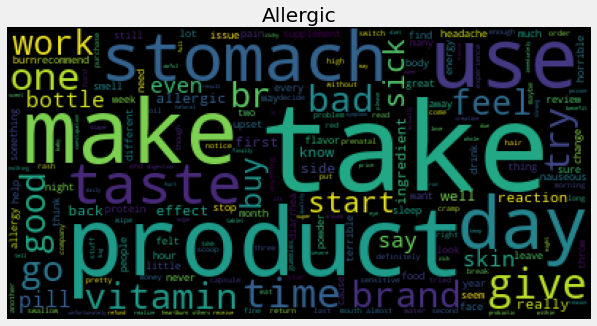

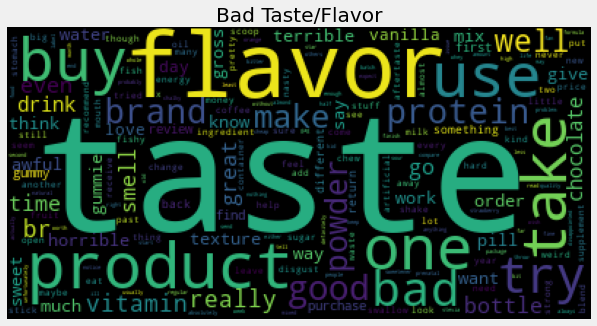

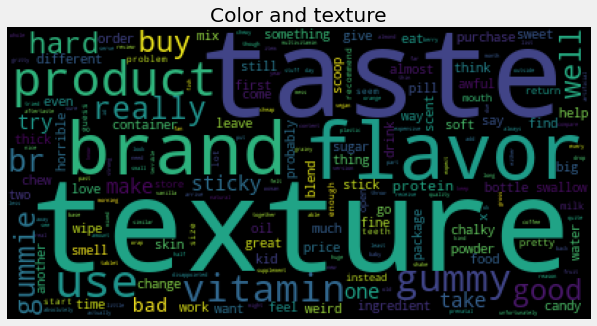

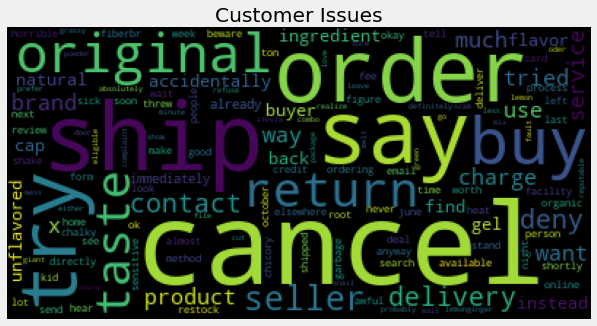

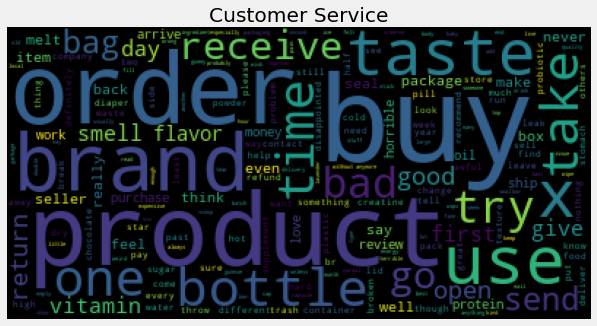

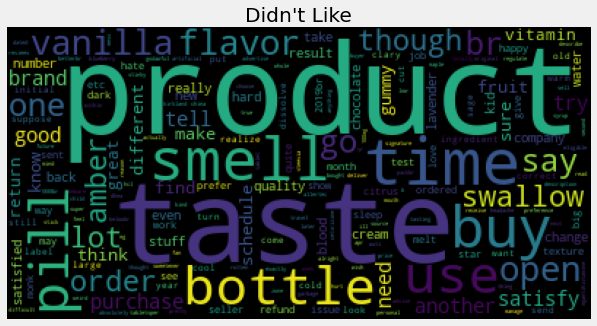

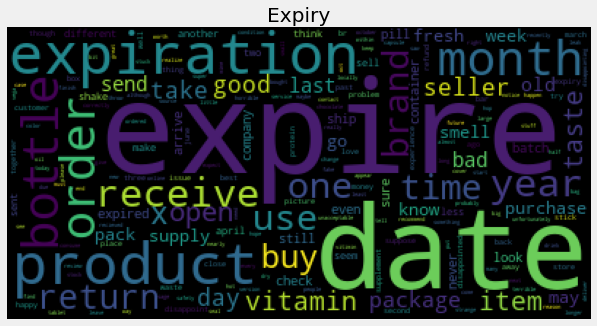

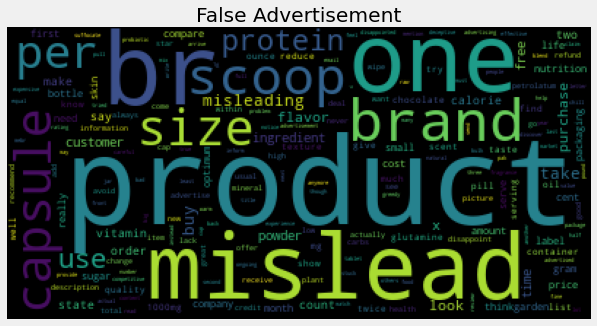

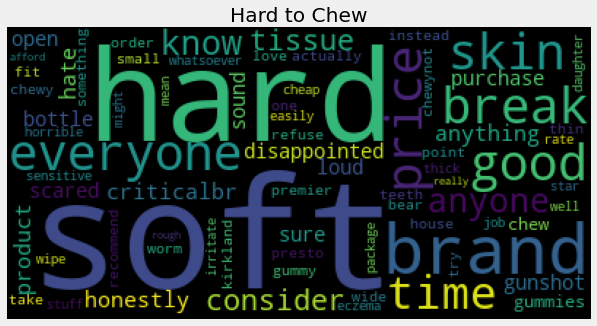

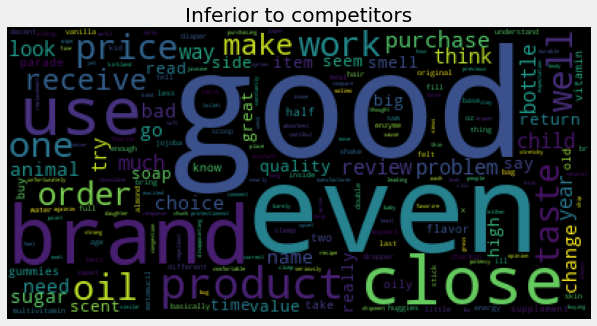

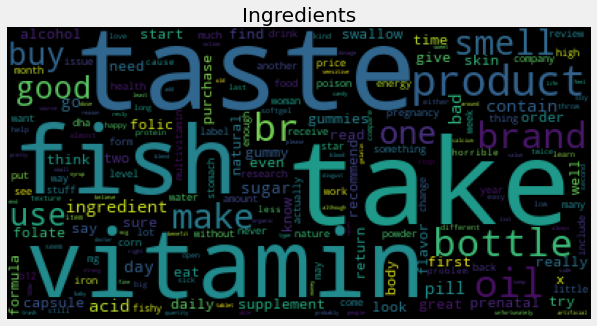

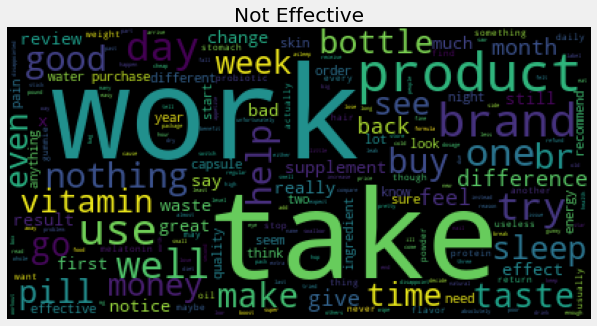

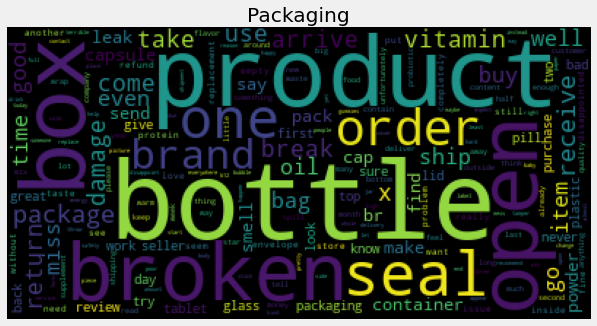

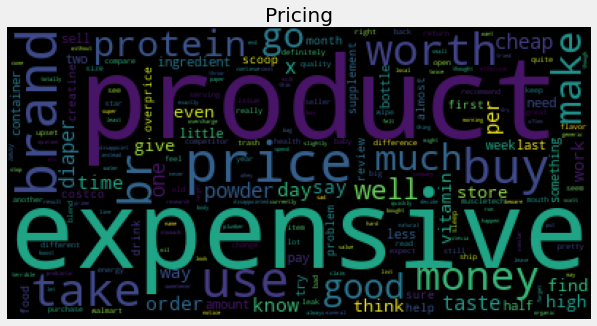

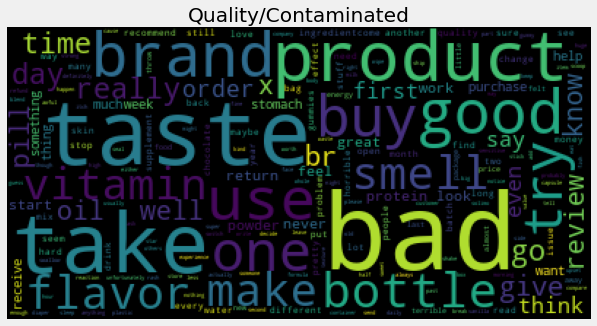

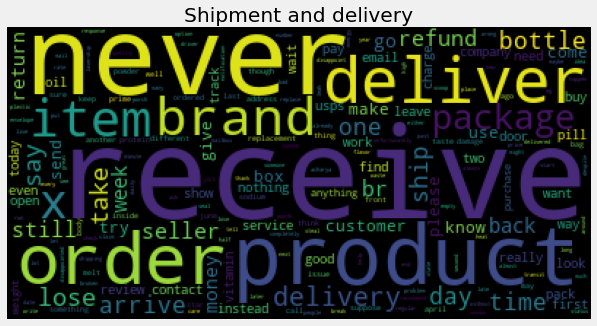

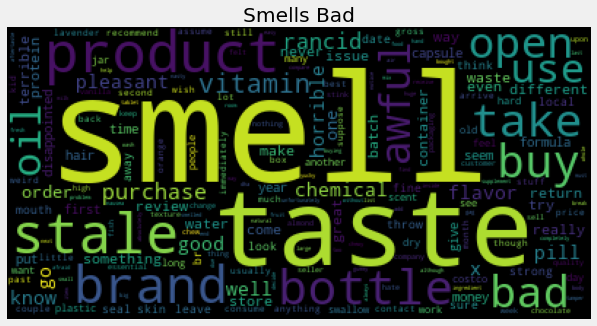

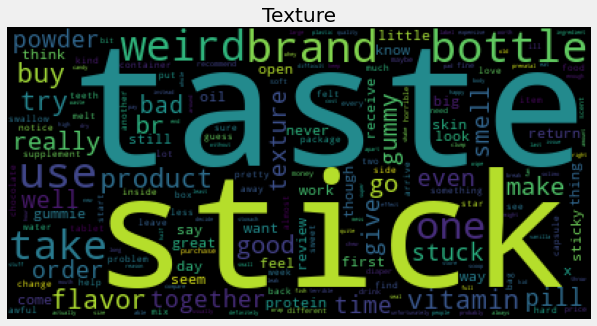

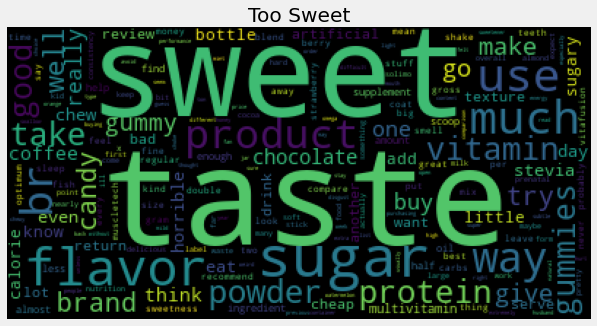

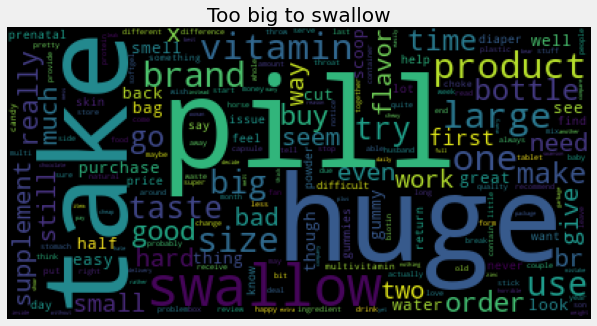

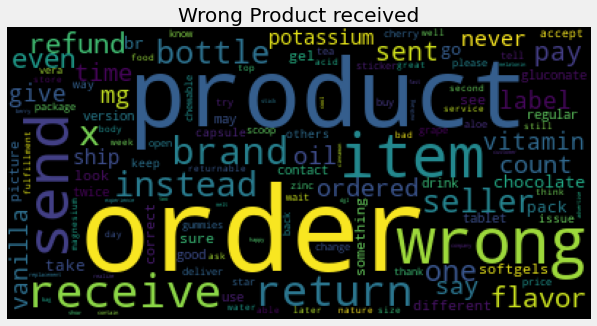

In [24]:
from wordcloud import WordCloud, STOPWORDS

for topic in topics :
    all_reviews = data[data[topic] == 1]['Review Text'].apply(lambda x : ' '.join(x))
    Corpus = ' '.join(all_reviews)
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color='black', collocations=False).generate(Corpus)
    fig = plt.figure(figsize = (10,5))
    plt.title(topic)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
